In [1]:
%%bash
pip install WordCloud
pip install nltk

You are using pip version 18.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from fastai.text import *
import html
import pandas as pd
from src.text_tools import fixup, get_texts, get_all
from sklearn.utils import class_weight
from src.utils import plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
%load_ext autoreload
%autoreload 2

In [3]:
PATH = Path('/data/smith-monuments-sentiment/data')
RDUAA_PATH = PATH/'RDUAA'/'v1'

In [4]:
#df = pd.read_csv(RDUAA_PATH/'predictions_v1.csv', sep='|')
#df_no_dup = df[['text']].groupby(df[['text']].columns.tolist()).size().reset_index().rename(columns={0:'dup_count'})

In [5]:
#dups_i = df.text.duplicated() 
#df_no_dup_full = df[~dups_i]
#df_no_dup_full['dup_count'] = df_no_dup['dup_count'].values
#df_no_dup_full.to_csv(RDUAA_PATH/'predictions_no_dup_v1.csv', index=False, sep='|') 

In [6]:
df_no_dup = pd.read_csv(RDUAA_PATH/'predictions_no_dup.csv', sep='|')

In [7]:
'''
df_full = pd.read_csv(RDUAA_PATH/'PC-RDUAA.csv')
text, idx, counts = np.unique(df_full.text, return_index=True, return_counts=True)
df_uniq = df_full.iloc[idx]
df_uniq['dup_count']=counts
df_uniq = df_uniq.sort_values('dup_count', ascending=False).reset_index(drop=True)
df_uniq=df_uniq.merge(df_no_dup[['id','pred_sentiment','0_prob', '1_prob', '2_prob']], on='id')
#to_csv
df_uniq.to_csv(RDUAA_PATH/'predictions_no_dup.csv', sep='|', index=False)
'''

"\ndf_full = pd.read_csv(RDUAA_PATH/'PC-RDUAA.csv')\ntext, idx, counts = np.unique(df_full.text, return_index=True, return_counts=True)\ndf_uniq = df_full.iloc[idx]\ndf_uniq['dup_count']=counts\ndf_uniq = df_uniq.sort_values('dup_count', ascending=False).reset_index(drop=True)\ndf_uniq=df_uniq.merge(df_no_dup[['id','pred_sentiment','0_prob', '1_prob', '2_prob']], on='id')\n#to_csv\ndf_uniq.to_csv(RDUAA_PATH/'predictions_no_dup.csv', sep='|', index=False)\n"

In [8]:
test_label_no_dup = df_no_dup.pred_sentiment

(-1.4323732443634059,
 1.429350474046187,
 -1.1019194191930555,
 1.1124767741613533)

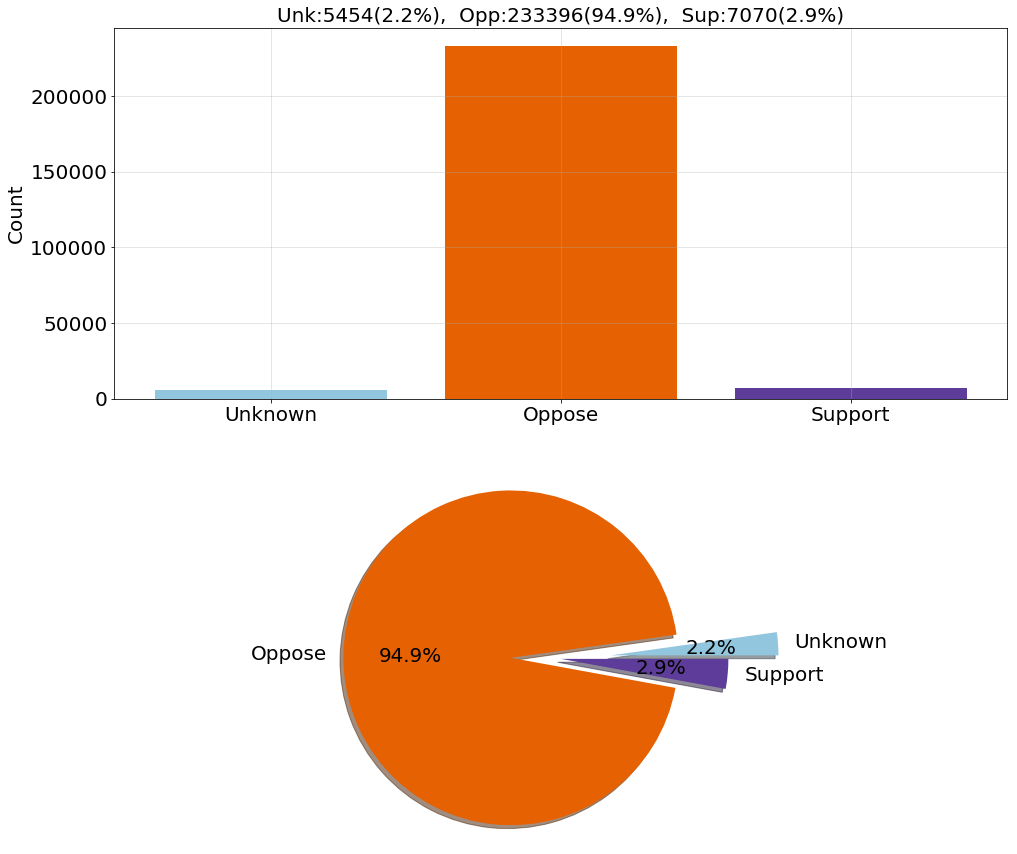

In [55]:
bins = np.bincount(test_label_no_dup)
lcp = bins/len(test_label_no_dup)*100
#colors = ['royalblue','orange','forestgreen']
colors = ['#92c5de','#e66101', '#5e3c99']
labels = ['Unknown', 'Oppose', 'Support']
title = 'Unk:%i(%0.1f%%),  Opp:%i(%0.1f%%),  Sup:%i(%0.1f%%)'\
                %(bins[0],lcp[0],bins[1],lcp[1],bins[2],lcp[2])
f, ax = plt.subplots(2,1,figsize=(16,15))
#ax[0].hist(test_label_no_dup, bins=3)
ax[0].bar(np.arange(len(bins)), bins, align='center', color=colors)
ax[0].grid(alpha=0.5)
ax[0].set_title(title, fontsize=20)
ax[0].grid(alpha=0.4)
ax[0].set_xticks(np.arange(3))
ax[0].set_xticklabels(labels, fontsize=20)
ax[0].set_xlabel('')
ax[0].set_ylabel('Count', fontsize=20)
ax[0].tick_params(axis='both', labelsize=20)
sizes = lcp
explode = (0.3, 0.3, 0)
ax[1].pie(bins, explode=explode, labels=labels, autopct='%1.1f%%', \
          colors=colors,shadow=True, textprops={'fontsize':20})
ax[1].axis('equal')

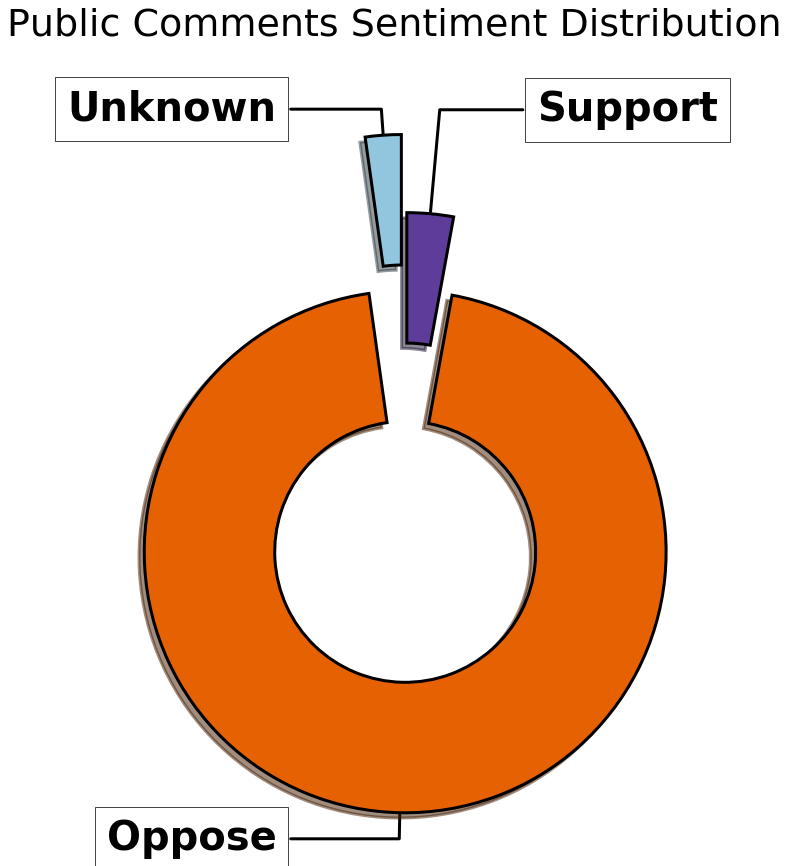

In [56]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(aspect="equal"))
wedge_props = dict(width=0.5, edgecolor='k', linewidth=3)
wedges, texts = ax.pie(bins, explode=explode, wedgeprops=wedge_props,colors=colors,\
                       shadow=True, startangle=90)

bbox_props = dict(boxstyle="square,pad=0.3", lw=0.72, fc="w", ec="k")
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-",\
                                                              lw=3,color='k'),
          bbox=bbox_props, zorder=0, va="center")

labels = ['Unknown', 'Oppose', 'Support']
#titles = ['%s (%0.1f%%)'%(i,j) for i,j in zip(labels,lcp)]
titles = ['%s'%(i) for i,j in zip(labels,lcp)]

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update(dict(connectionstyle=connectionstyle))
    ax.annotate(titles[i], xy=(x, y), xytext=(0.5*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment,\
                 fontsize=40, weight='bold', **kw)

#plt.show()
fig.text(0.05,1.01,'Public Comments Sentiment Distribution', fontsize=38, color='k')

#fig.suptitle('Public Comments Sentiment Distribution', fontsize=35, color='k')
fig.savefig(RDUAA_PATH/'pie.png', bbox_inches='tight', pad_inches=0)

In [11]:
neg_comments = df_no_dup.text[df_no_dup.pred_sentiment==2]
pos_comments = df_no_dup.text[df_no_dup.pred_sentiment==1]
neu_comments = df_no_dup.text[df_no_dup.pred_sentiment==0]
neg = " ".join(c for c in neg_comments)
pos = " ".join(c for c in pos_comments)

In [34]:
stopwords = ['xbos', 'xfld', '\n', 'and', 'of', 'the', 'in', 'or','on','only','do'\
             'Comment', 'my', 'this', 'Your', 'there', 'by', 'if', 'Write','any','had',\
            'are', 'to', 'but', 'that', 'they', 'it', 'Here', 'is', 'at','which', 'where',\
            'because', 'we', 'has', 'some', 'so', 'also', 'been', 'get', 'as', 'it','when',\
            'an', 'these', 'National', 'Monument','with', 'Ryan', 'Zinke',\
            'Secretary', 'area', 'for', 'have', 'would', 'be']
neg_wordcloud = WordCloud(max_words=100, min_font_size=9, \
                          background_color='white',stopwords=stopwords).generate(neg)
pos_wordcloud = WordCloud(max_words=100, min_font_size=9, \
                          background_color='white',stopwords=stopwords).generate(pos)

In [48]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
purpleBig = cm.get_cmap('Purples_r', 512)
newpurple = ListedColormap(purpleBig(np.linspace(0, 0.5, 256)))
orangeBig = cm.get_cmap('Oranges_r', 512)
neworange = ListedColormap(orangeBig(np.linspace(0, 0.5, 256)))
neg_wordcloud.recolor(colormap=newpurple)
pos_wordcloud.recolor(colormap=neworange)

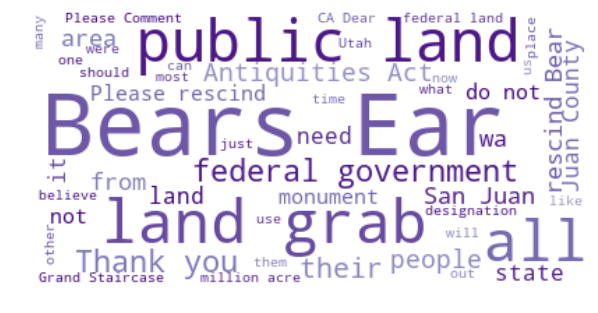

In [49]:
f, ax = plt.subplots(1,1,figsize=(10,20))
ax.imshow(neg_wordcloud, interpolation='bilinear')
ax.axis('off')
f.savefig(RDUAA_PATH/'neg_comments_v2.png', bbox_inches='tight', pad_inches=0)

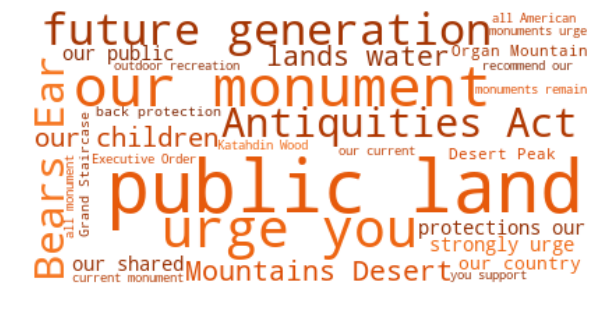

In [50]:
f, ax = plt.subplots(1,1,figsize=(10,20))
ax.imshow(pos_wordcloud, interpolation='bilinear')
ax.axis('off')
f.savefig(RDUAA_PATH/'pos_comments_v2.png', bbox_inches='tight', pad_inches=0)

In [13]:
n_n = len(neg_comments)
n_p = len(pos_comments)
print(int(np.round(n_n/(n_n+n_p)*100)))

3


In [14]:
#most_dup = np.max(df_no_dup.dup_count)
#df_no_dup[df_no_dup.dup_count>=most_dup].text.values

# add infographics here

In [15]:
from matplotlib import patches
from matplotlib import path as mpath

def clamp(x): 
    return max(0, min(x, 255))

def human():
    #fleshtone = ['tan', 'bisque', ]
    r,g,b = 165, 126, 110
    tone = "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))
    face = patches.Circle((0,0), radius = 10, fc=tone, color = 'black', linewidth=2)
    lefteye = patches.Circle((-5,3.5), radius = 2, fc='white', color='black', linewidth=2)
    righteye = patches.Circle((5,3.5), radius = 2, fc='white', color='black', linewidth=2)
    return(face, lefteye, righteye)

def robot():
    face = patches.Rectangle((-10,-10), width=20, height=20, fc='grey', color = 'black', linewidth=2)
    lefteye = patches.Circle((-5,3.5), radius = 2, fc='white', color='black', linewidth=2)
    righteye = patches.Circle((5,3.5), radius = 2, fc='white', color='black', linewidth=2)
    return(face, lefteye, righteye)

def paper():
    x = [10,-7.5,-10,7.5]
    y = [10,10,-10,-10]
    face = patches.Polygon(xy=list(zip(x,y)), fc='white', color='black', linewidth=2)
    verts = [(-5,5),(6,5),\
            (-6,0),(5,0),\
            (-7,-5),(4,-5)]
    codes = [mpath.Path.MOVETO,mpath.Path.LINETO,\
            mpath.Path.MOVETO,mpath.Path.LINETO,\
            mpath.Path.MOVETO,mpath.Path.LINETO]
    lines = patches.PathPatch(mpath.Path(verts,codes), facecolor='black', linewidth=2)
    return(face,lines)

def sentiment_marker(s):
    #colors = ['orange','green']
    colors = ['#e66101', '#5e3c99']
    sentiment_mark = patches.Circle((9,9), radius=4, fc=colors[s])
    return(sentiment_mark)

In [16]:
total = np.sum(df_no_dup.dup_count)
print(total)
cs = np.load(RDUAA_PATH/'cosinesimilarity_scores_v1.npy')
csm = np.load('/data/smith-monuments-sentiment/data/RDUAA/v1/cosine_similarity_max_v1.npy')
thr = 80 
form_mask = ((csm[0]>=thr) & (df_no_dup.pred_sentiment!=0) & (df_no_dup.dup_count==1))
#form_mask = ((cs[thr]) & (df_no_dup.pred_sentiment!=0) & (df_no_dup.dup_count==1))
#so the distinguishing factor of form vs bot, is that the bots are duplicated
bot_mask = (df_no_dup.dup_count>1) & (df_no_dup.pred_sentiment!=0)
human_mask = (~form_mask & ~bot_mask)
#df_no_dup[human_mask].to_csv(RDUAA_PATH/'human_comments_v1.csv', index=False, sep='|')

754706


In [17]:
#how many documents are basically 95 similar, must be form letters, if not fully verbatim?
#first we have a filter that removes anything with a neutral sentiment
formcnt = np.sum(df_no_dup[form_mask].dup_count)
nncnt = np.sum(df_no_dup[df_no_dup.pred_sentiment!=0].dup_count)
botcnt = np.sum(df_no_dup[bot_mask].dup_count)
humancnt = nncnt-(botcnt+formcnt)
print('counts:\t\t', botcnt, formcnt, humancnt)
print('sum\t\t', botcnt+formcnt+humancnt)
percent_bot = int(np.round((botcnt/nncnt)*100))
percent_form = int(np.round((formcnt/nncnt)*100))
percent_human = int(np.round(((nncnt-botcnt-formcnt)/nncnt)*100))
print('percents:\t', percent_bot, percent_form, percent_human)
print('total:\t\t',np.sum(df_no_dup.dup_count))
print('total (unk):\t',np.sum(df_no_dup[df_no_dup.pred_sentiment==0].dup_count))

counts:		 515193 83292 148048
sum		 746533
percents:	 69 11 20
total:		 754706
total (unk):	 8173


In [18]:
form_grid = []
for thr in range(100):
    form_mask = ((csm[0]>=thr) & (df_no_dup.pred_sentiment!=0) & (df_no_dup.dup_count==1))
    formcnt = np.sum(df_no_dup[form_mask].dup_count)
    form_grid.append(formcnt)

In [19]:
df_no_dup[bot_mask].dup_count.sort_values()

245678        2
92571         2
92497         2
92452         2
92380         2
92233         2
92209         2
92148         2
92090         2
92086         2
92058         2
92041         2
92014         2
91953         2
91845         2
91829         2
91772         2
91657         2
91517         2
91429         2
91409         2
91375         2
91320         2
91281         2
91252         2
195991        2
92613         2
92621         2
92667         2
92682         2
          ...  
203332     2176
174778     2217
223230     2289
226959     2375
129730     2570
31751      2706
21201      2770
4997       2803
232705     2963
230482     2980
128075     3295
174621     3499
226576     3781
202903     3990
227167     4049
186147     4757
188543     4826
168102     6339
157264     6559
3512       6931
172931     7594
226756    10642
224978    11888
179923    12135
172933    16164
223983    34276
172936    39483
168097    42877
172918    92020
13636     99748
Name: dup_count, Length:

In [20]:
df_no_dup.text

0             1. I WANT ALL 27 NAT'L MONUMENTS TO REMAIN...
1             All National Monuments established since 1...
2             As the U.S. population continues to grow, ...
3             Bears Ears National Monument was a signifi...
4             Bears Ears monument and other monuments/ n...
5             Berryessa Snow Mountain    Carrizo Plain  ...
6             Change the protected status of magnificent...
7             Dear Secretary Ryan Zinke,  I am writing t...
8             Dear Secretary Ryan Zinke, I am a former U...
9             Dear Secretary Zinke,Thank you for walking...
10            I am writing in response to the executive ...
11            I am writing in support of maintaining the...
12            I strongly oppose any effort to eliminate ...
13            I support the designation and expansion of...
14            I support the designation and expansion of...
15            I support the designation and expansion of...
16            I support the designation 

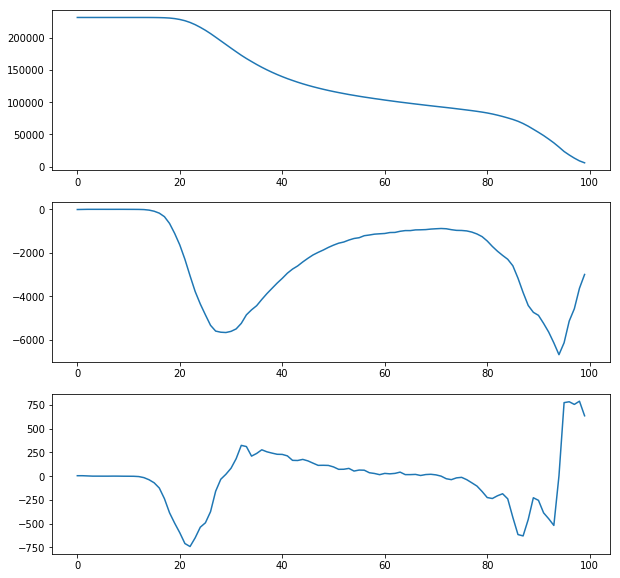

In [21]:
f, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(np.arange(100), np.array(form_grid))
ax[1].plot(np.arange(100), np.gradient(np.array(form_grid)))
ax[2].plot(np.arange(100), np.gradient(np.gradient(np.array(form_grid))))

In [22]:
pos_human = df_no_dup[~(csm[0]>=thr) & (df_no_dup.pred_sentiment==1) & (df_no_dup.dup_count==1)]
neg_human = df_no_dup[~(csm[0]>=thr) & (df_no_dup.pred_sentiment==2) & (df_no_dup.dup_count==1)]
unk_human = df_no_dup[~(csm[0]>=thr) & (df_no_dup.pred_sentiment==0) & (df_no_dup.dup_count==1)]
pos_human_cnt = np.sum(pos_human.dup_count)
neg_human_cnt = np.sum(neg_human.dup_count)
unk_human_cnt = np.sum(unk_human.dup_count)
neg_human_perc = int(np.ceil(neg_human_cnt/(neg_human_cnt+pos_human_cnt)*100))

In [23]:
pos_bot = np.sum(df_no_dup[(bot_mask) & (df_no_dup.pred_sentiment==1)].dup_count)
neg_bot = np.sum(df_no_dup[(bot_mask) & (df_no_dup.pred_sentiment==2)].dup_count)
neg_bot_perc = int(np.ceil(neg_bot/(neg_bot+pos_bot)*100))
pos_form = np.sum(df_no_dup[(form_mask) & (df_no_dup.pred_sentiment==1)].dup_count)
neg_form = np.sum(df_no_dup[(form_mask) & (df_no_dup.pred_sentiment==2)].dup_count)
neg_form_perc = int(np.ceil(neg_form/(neg_form+pos_form)*100))
print(pos_bot, neg_bot, pos_form, neg_form, pos_human_cnt, neg_human_cnt)
print(neg_bot_perc, neg_form_perc, neg_human_perc)

513152 2041 5619 395 218774 6552
1 7 3


In [24]:
print('positive human all:',1-(neg_human_cnt/(neg_human_cnt+pos_human_cnt)))
print('positive form all:',1-(neg_form/(neg_form+pos_form)))
print('positive bots all:',1-(neg_bot/(neg_bot+pos_bot)))
#print(neg_human/(neg_bot+pos_bot)*100)

positive human all: 0.9709221306018835
positive form all: 0.9343199201862321
positive bots all: 0.9960383778506308


In [25]:
neg_human_tperc = neg_human_cnt/(total)*100
neg_bot_tperc = neg_bot/(total)*100
neg_form_tperc = neg_form/(total)*100
print(neg_human_tperc, neg_bot_tperc, neg_form_tperc)

0.86815263162079 0.2704364348501271 0.05233826152170514


In [26]:
def percent_index(n, percent):
    return(int(np.round(n*(percent/100))))

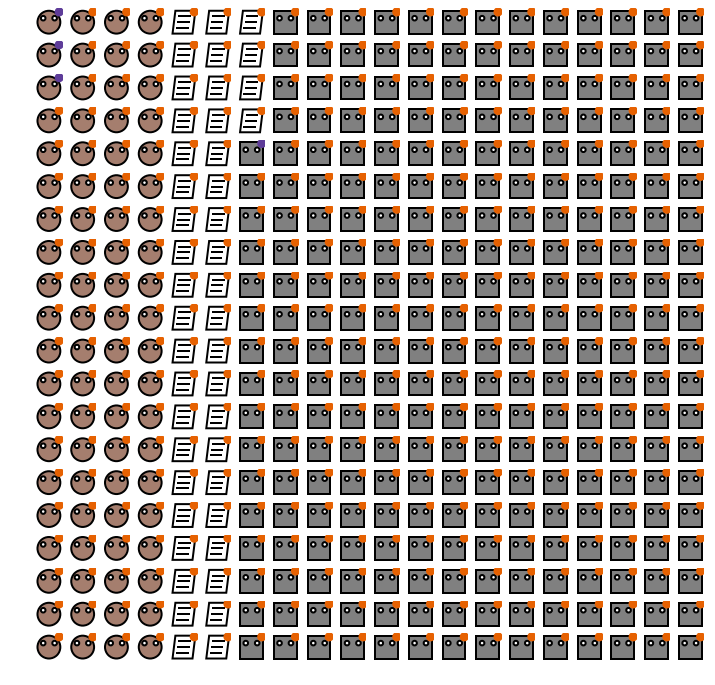

In [27]:
n = 20**2 
nn = int(np.sqrt(n))
f, ax = plt.subplots(nn,nn, figsize=(12,12))
mask = np.zeros(n)
mask[:percent_index(n,percent_human)] = 1
mask[percent_index(n,percent_human):(percent_index(n,percent_form) \
                                     + percent_index(n,percent_human))] = 2
mask = mask.reshape((nn,nn)).T
sentiment_mask = np.zeros(n).astype(int)
#first humans, then forms, then bots
sentiment_mask[:percent_index(n,neg_human_tperc)] = 1 #
sentiment_mask[percent_index(n,percent_human):percent_index(n,percent_human+\
                                                            neg_form_tperc)] = 1
sentiment_mask[percent_index(n,percent_human+\
                             percent_form):percent_index(n,percent_human+\
                                                            percent_form+neg_bot_tperc)] = 1
sentiment_mask = sentiment_mask.reshape((nn,nn)).T
for i in range(nn):
    for j in range(nn):
        if mask[i,j]==0:
            face, lefteye, righteye = robot()
            ax[i,j].add_patch(face)
            ax[i,j].add_patch(lefteye)
            ax[i,j].add_patch(righteye)
        elif mask[i,j]==1:
            face, lefteye, righteye = human()
            ax[i,j].add_patch(face)
            ax[i,j].add_patch(lefteye)
            ax[i,j].add_patch(righteye)
        else:
            face,lines = paper()
            ax[i,j].add_patch(face)
            ax[i,j].add_patch(lines)
        sentiment_mark = sentiment_marker(int(sentiment_mask[i,j]))
        ax[i,j].add_patch(sentiment_mark)
        ax[i,j].axis('off')
        ax[i,j].set_xlim([-12,12])
        ax[i,j].set_ylim([-12,12])
        ax[i,j].set_aspect('equal')

f.savefig(RDUAA_PATH/'humans_vs_bots_v2.png', bbox_inches='tight', pad_inches=0)

In [24]:
pos_comments = pos_human.text
neg_comments = neg_human.text
neg = " ".join(c for c in neg_comments)
pos = " ".join(c for c in pos_comments)

In [82]:
# Apply our color function
stopwords = ['xbos', 'xfld', '\n', 'and', 'of', 'the', 'in', 'or','on','only','do'\
             'comment', 'my', 'this', 'your', 'there', 'by', 'if', 'write','any','had',\
            'are', 'to', 'but', 'that', 'they', 'it', 'here', 'is', 'at','which', 'where',\
            'because', 'we', 'has', 'some', 'so', 'also', 'been', 'get', 'as', 'it','when',\
            'an', 'these', 'national', 'monument','with', 'for', 'all','was','be','have',\
            'secretary', 'area', 'zinke', 'ryan', 'dear', 'wa']
neg_wordcloud = WordCloud(stopwords=stopwords, mode='RGBA',\
                          background_color=None, max_words=80, \
                          min_font_size=10).generate(neg.lower())
pos_wordcloud = WordCloud(stopwords=stopwords, mode='RGBA',\
                         background_color=None, max_words=80, \
                          min_font_size=10).generate(pos.lower())
neg_wordcloud.recolor(colormap='Greens_r')
pos_wordcloud.recolor(colormap='Oranges_r')

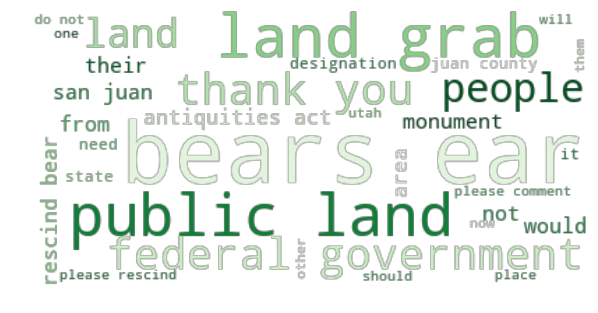

In [83]:
f, ax = plt.subplots(1,1,figsize=(10,20))
ax.imshow(neg_wordcloud, interpolation='bilinear')
ax.axis('off')
f.savefig(RDUAA_PATH/'neg_comments.png', bbox_inches='tight', pad_inches=0)

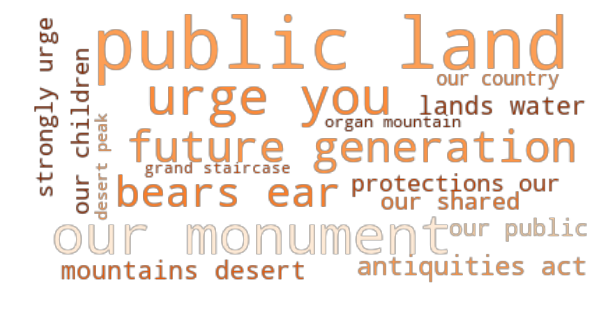

In [84]:
f, ax = plt.subplots(1,1,figsize=(10,20))
ax.imshow(pos_wordcloud, interpolation='bilinear')
ax.axis('off')
f.savefig(RDUAA_PATH/'pos_comments.png', bbox_inches='tight', pad_inches=0)

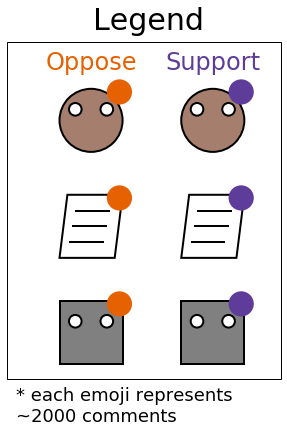

In [53]:
#let's first make the legend
#then we will combine images together to form a final image
###LEGEND
n=3
m=2
mask = np.array([[1,1],[2,2],[0,0]])
sentiment_mask = np.array([[0,1],[0,1],[0,1]])
f, ax = plt.subplots(n,m, figsize=(4,6))
for i in range(n):
    for j in range(m):
        if mask[i,j]==0:
            face, lefteye, righteye = robot()
            ax[i,j].add_patch(face)
            ax[i,j].add_patch(lefteye)
            ax[i,j].add_patch(righteye)
        elif mask[i,j]==1:
            face, lefteye, righteye = human()
            ax[i,j].add_patch(face)
            ax[i,j].add_patch(lefteye)
            ax[i,j].add_patch(righteye)
        else:
            face,lines = paper()
            ax[i,j].add_patch(face)
            ax[i,j].add_patch(lines)
        sentiment_mark = sentiment_marker(int(sentiment_mask[i,j]))
        ax[i,j].add_patch(sentiment_mark)
        #ax[i,j].axis('off')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False) 
        ax[i,j].patch.set_alpha(0.0)
        ax[i,j].set_xlim([-14,14])
        ax[i,j].set_ylim([-14,14])
        ax[i,j].set_aspect('equal')
ax[0,0].set_ylabel('Human', fontsize=26, color='white')
ax[1,0].set_ylabel('Form', fontsize=26, color='white')
ax[2,0].set_ylabel('Bot', fontsize=26, color='white')
ax[0,0].set_title('Oppose', fontsize=24, color=colors[1])
ax[0,1].set_title('Support', fontsize=24, color=colors[2])
#f.text(-0.08, 0.5, '5K individuals', va='center', \
#       ha='center', rotation='vertical', fontsize=28)
f.patch.set_facecolor('white')
f.suptitle('Legend', color='k', fontsize=30)
f.subplots_adjust(top=0.82)
#patches.FancyBboxPatch((0.01,0.12),0.95,0.78, fill=False, color='white')
f.patches.extend([plt.Rectangle((0.01,0.12),0.95,0.78,
                                  fill=False, color='k',
                                  transform=f.transFigure, figure=f)])
f.text(0.04,0.02,'* each emoji represents \n~2000 comments', fontsize=18, color='k')
f.savefig(RDUAA_PATH/'legend.png', bbox_inches='tight', pad_inches=0)

In [54]:
print(RDUAA_PATH)

/data/smith-monuments-sentiment/data/RDUAA/v1


In [113]:
#now combine all the images together to form final infographic
import numpy as np
import PIL
image_list = [('%s/%s'%(str(RDUAA_PATH),i)) for i in ['legend.png', 'pos_comments.png', \
                'neg_comments.png', 'humans_vs_bots.png','pie.png']]
imgs = [PIL.Image.open(i) for i in image_list]